In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
from torchvision.models import resnet50
import torchaudio.transforms as T
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')
data_dir = '/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings'

In [4]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [5]:
NUM_SAMPLES = 11022
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
random_seed = 10
train_size = 0.8

In [6]:
recordings_old = sorted(os.listdir(data_dir))

In [7]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [8]:
len(recordings)

2903

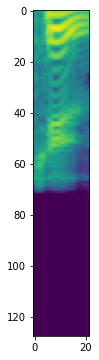

In [9]:
y, _ = librosa.load(data_dir + '/' + recordings[700], sr = sr)
samples = y[:NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec, ref=np.max)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [10]:
image_size = melspec.shape
image_size

(128, 22)

In [11]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def freq_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = 0.0
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = 0.0
    return image

def random_erasing(image, max_a = 12, max_b = 2):
    a = np.random.randint(max_a)
    b = np.random.randint(max_b)
    a0 = np.random.randint(image.shape[1] - a)
    b0 = np.random.randint(image.shape[2] - b)
    image[:, a0 : a0 + a, b0 : b0 + b] = 0.0
    return image

def loudness_conrol(image):
    min_value = torch.min(image)
    lyambda = np.random.rand() * 0.4
    image = min_value + lyambda * (image - min_value)
    return image
    
def FreqNoising(image, var = 0.1, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(image.shape[1] - a)
    noise = var * torch.randn(a, image.shape[2])
    image[0, a0: a0 + a, :] += noise
    image[1, a0: a0 + a, :] += noise
    image[2, a0: a0 + a, :] += noise
    return image

def TimeNoising(image, var = 0.1, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(image.shape[2] - b)
    noise = var * torch.randn(image.shape[1], b)
    image[0, :, b0: b0 + b] += noise
    image[1, :, b0: b0 + b] += noise
    image[2, :, b0: b0 + b] += noise
    return image

def TimeCycleShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def FreqCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, image.shape[1] - shift:, :].clone()
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = t
    else:
        t = image[:, :shift, :].clone()
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = t
    return image

def TimeSpecialShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
    return image

def FreqSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
    return image

def FreqSwapAugmentation(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - a)
    t = image[:, a0 : a0 + a, :].clone()
    image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    image[:, a0 - a: a0, :] = t
    return image

def TimeSwapAugmentation(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def FreqReplyMasking(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - 2 * a)
    p = np.random.rand()
    if p < 0.5:
        image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    else:
        image[:,  a0 : a0 + a, :] = image[:, a0 + a : a0 + 2 * a, :]
    return image

def TimeReplyMasking(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 2):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def FreqRandomSwap(image, max_a = 12):
    a = np.random.randint(max_a)
    a1 = np.random.randint(image.shape[1] - a)
    while True:
        a2 = np.random.randint(image.shape[1] - a)
        if np.abs(a1 - a2) >= a:
            t = image[:, a1 : a1 + a, :].clone()
            image[:, a1 : a1 + a, :] = image[:, a2 : a2 + a, :]
            image[:, a2 : a2 + a, :] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(2)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(12)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 12, 2)
    if mode == 'FreqShift':
        return freq_shift_augmentation(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'LoudnessControl':
        return loudness_conrol(image)
    if mode == 'TimeNoising':
        return TimeNoising(image)
    if mode == 'FreqNoising':
        return FreqNoising(image)
    if mode == 'FreqCycleShift':
        return FreqCycleShift(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'FreqSpecialShift':
        return FreqSpecialShift(image)
    if mode == 'TimeSpecialShift':
        return TimeSpecialShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'FreqSwapAugmentation':
        return FreqSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'FreqReplyMasking':
        return FreqReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'FreqRandomSwap':
        return FreqRandomSwap(image)
    
    
    return image

In [12]:
def get_spectrogram(filename):
    y, _ = librosa.load(filename, sr = sr)
    samples = y[:NUM_SAMPLES]
    melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
    melspec = librosa.power_to_db(melspec)
    melspec = normalize(melspec, mean=None, std=None)
    return torch.tensor(melspec, dtype=torch.float32)

In [13]:
data = []
labels = []
for i in range(len(recordings)):
    data.append(get_spectrogram(data_dir + '/' + recordings[i]))
    labels.append(int(recordings[i][0]))

In [14]:
keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

In [15]:
class AudioMNIST(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = [], augment = False, aug_type = 'No'):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        self.augment = augment
        self.aug_type = aug_type
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        if self.augment:
            X = augmentation(X, self.aug_type)
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, augment = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    for epoch in range(epochs):
        print('epoch:', epoch)
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)

        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        print('Train')
        print(mean_loss)

        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)

        print('TEST')
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        print('loss:', mean_loss)
        print('accuracy:', mean_accuracy)
        print('******************')
    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_acc

In [17]:
def evaluate(model, test_loader):
    model.eval()
    #all_preds = []
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)
            #all_preds.append(preds)

    mean_accuracy = sum_accuracy / cnt_objects
    print('Quality of the model')
    print('accuracy:', mean_accuracy)

## Resnet18

### No augmentation

In [18]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = False, keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch: 0
Train
1.1774875581039814
TEST
loss: 1.0703614132378692
accuracy: 0.7720430107526882
******************
epoch: 1
Train
0.482656646686404
TEST
loss: 0.981754005852566
accuracy: 0.7247311827956989
******************
epoch: 2
Train
0.49348059814979006
TEST
loss: 0.4584287348613944
accuracy: 0.864516129032258
******************
epoch: 3
Train
0.3565693809322343
TEST
loss: 0.7407933642787318
accuracy: 0.7784946236559139
******************
epoch: 4
Train
0.3331921484178924
TEST
loss: 0.43365583778709493
accuracy: 0.875268817204301
******************
epoch: 5
Train
0.30612847602168397
TEST
loss: 0.6207352363935081
accuracy: 0.853763440860215
******************
epoch: 6
Train
0.2580126957926753
TEST
loss: 0.5252475182215373
accuracy: 0.8709677419354839
******************
epoch: 7
Train
0.24183614960458885
TEST
loss: 0.30970752905773863
accuracy: 0.9118279569892473
******************
epoch: 8
Train
0.1793071845477155
TEST
loss: 0.30213547278476016
accuracy: 0.9118279569892473
**********

In [19]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9535283993115319


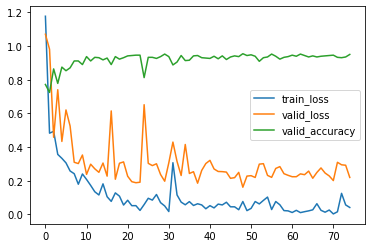

In [20]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeMasking

In [21]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.2056154142353055
TEST
loss: 1.4265924658826603
accuracy: 0.7268817204301076
******************
epoch: 1
Train
0.5187374650629606
TEST
loss: 0.4260543643787343
accuracy: 0.8688172043010752
******************
epoch: 2
Train
0.3574949639037404
TEST
loss: 1.165889584633612
accuracy: 0.6860215053763441
******************
epoch: 3
Train
0.4230905064473437
TEST
loss: 0.4925269265328684
accuracy: 0.8580645161290322
******************
epoch: 4
Train
0.3253293913028288
TEST
loss: 0.44315105817651235
accuracy: 0.8451612903225807
******************
epoch: 5
Train
0.3698467915585815
TEST
loss: 0.41816230576525454
accuracy: 0.8580645161290322
******************
epoch: 6
Train
0.3094816485206222
TEST
loss: 0.43560802808371923
accuracy: 0.8795698924731182
******************
epoch: 7
Train
0.24802033969902773
TEST
loss: 0.3752278454842106
accuracy: 0.9075268817204301
******************
epoch: 8
Train
0.2733951012293498
TEST
loss: 0.29705563219644693
accura

In [22]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9466437177280551


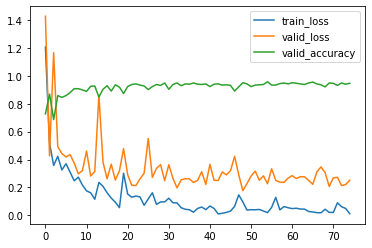

In [23]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqMasking

In [24]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.3848600566676053
TEST
loss: 0.9780931298450757
accuracy: 0.7591397849462366
******************
epoch: 1
Train
0.6020848503277131
TEST
loss: 0.48696279602666054
accuracy: 0.832258064516129
******************
epoch: 2
Train
0.47450331455286177
TEST
loss: 0.6600416906418339
accuracy: 0.7978494623655914
******************
epoch: 3
Train
0.45120022074792354
TEST
loss: 0.29145966511900706
accuracy: 0.9032258064516129
******************
epoch: 4
Train
0.37197429734529447
TEST
loss: 0.65259369163103
accuracy: 0.8494623655913979
******************
epoch: 5
Train
0.2998208923563241
TEST
loss: 0.5200562310475175
accuracy: 0.864516129032258
******************
epoch: 6
Train
0.2909468839293086
TEST
loss: 0.3079127063033401
accuracy: 0.9118279569892473
******************
epoch: 7
Train
0.20897132598012125
TEST
loss: 0.3375013698813736
accuracy: 0.9182795698924732
******************
epoch: 8
Train
0.24789821344097263
TEST
loss: 0.5584849173022854
accurac

In [25]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9569707401032702


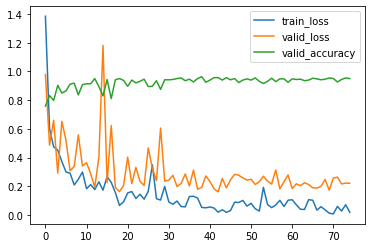

In [26]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### Noise

In [27]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'Noise', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.0590874606971146
TEST
loss: 1.7506361453763901
accuracy: 0.7182795698924731
******************
epoch: 1
Train
0.5092224642096762
TEST
loss: 0.9447117259425502
accuracy: 0.7569892473118279
******************
epoch: 2
Train
0.4125545678372401
TEST
loss: 0.46416401452915645
accuracy: 0.8774193548387097
******************
epoch: 3
Train
0.240921151496803
TEST
loss: 0.579176890465521
accuracy: 0.843010752688172
******************
epoch: 4
Train
0.25683011454026033
TEST
loss: 0.6236022550572631
accuracy: 0.8279569892473119
******************
epoch: 5
Train
0.30304310518564176
TEST
loss: 0.8710402668163341
accuracy: 0.8064516129032258
******************
epoch: 6
Train
0.25242862492141765
TEST
loss: 0.4020220006665876
accuracy: 0.8946236559139785
******************
epoch: 7
Train
0.20680338539098883
TEST
loss: 0.2205599339418514
accuracy: 0.9268817204301075
******************
epoch: 8
Train
0.2369366815543393
TEST
loss: 0.2492409054951001
accuracy

In [28]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9466437177280551


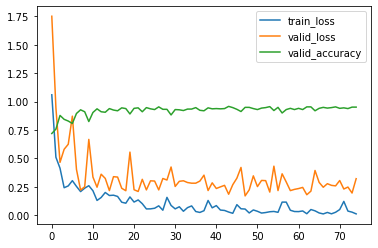

In [29]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### RandomErasing

In [30]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'RandomErasing', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.1978792639014924
TEST
loss: 1.0365694815112698
accuracy: 0.7462365591397849
******************
epoch: 1
Train
0.5013223901254616
TEST
loss: 0.39167419889921784
accuracy: 0.886021505376344
******************
epoch: 2
Train
0.4304642299201197
TEST
loss: 0.8086854832146757
accuracy: 0.8086021505376344
******************
epoch: 3
Train
0.3460567527133159
TEST
loss: 0.652344084555103
accuracy: 0.8473118279569892
******************
epoch: 4
Train
0.3219065472331173
TEST
loss: 0.3727314413234752
accuracy: 0.896774193548387
******************
epoch: 5
Train
0.3676125492918665
TEST
loss: 0.3487315163817457
accuracy: 0.8903225806451613
******************
epoch: 6
Train
0.2612443594246958
TEST
loss: 0.3737521549706818
accuracy: 0.8838709677419355
******************
epoch: 7
Train
0.21570269037268788
TEST
loss: 0.25805350798432547
accuracy: 0.9161290322580645
******************
epoch: 8
Train
0.16579943149078258
TEST
loss: 0.41046428129237184
accuracy

In [31]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.955249569707401


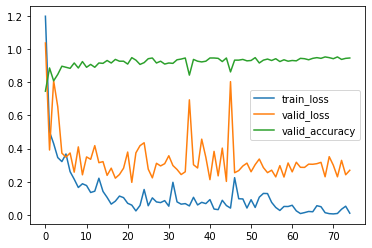

In [32]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeShift

In [33]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.2430085723735211
TEST
loss: 1.175729710568664
accuracy: 0.6946236559139785
******************
epoch: 1
Train
0.5494984663746083
TEST
loss: 0.5121508621400402
accuracy: 0.8473118279569892
******************
epoch: 2
Train
0.4472281459074991
TEST
loss: 0.5260036081396123
accuracy: 0.8365591397849462
******************
epoch: 3
Train
0.3722929881347015
TEST
loss: 0.34558927987211496
accuracy: 0.9075268817204301
******************
epoch: 4
Train
0.3375635967180173
TEST
loss: 0.3369037793528649
accuracy: 0.9010752688172043
******************
epoch: 5
Train
0.35129138687700756
TEST
loss: 0.7612923990013779
accuracy: 0.810752688172043
******************
epoch: 6
Train
0.37167538387132193
TEST
loss: 0.6001348971038736
accuracy: 0.810752688172043
******************
epoch: 7
Train
0.3129910022325264
TEST
loss: 0.3658579170062978
accuracy: 0.8881720430107527
******************
epoch: 8
Train
0.22268022209261462
TEST
loss: 0.3211743204824386
accuracy:

In [34]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


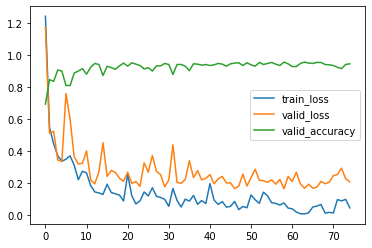

In [35]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqShift

In [36]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
2.1197295681917994
TEST
loss: 1.5050764727336103
accuracy: 0.4924731182795699
******************
epoch: 1
Train
1.6803889824102562
TEST
loss: 1.491508464659414
accuracy: 0.46881720430107526
******************
epoch: 2
Train
1.5544475566718163
TEST
loss: 0.8807704866573375
accuracy: 0.6946236559139785
******************
epoch: 3
Train
1.2893246495088198
TEST
loss: 0.5558969969390541
accuracy: 0.821505376344086
******************
epoch: 4
Train
1.1915207483079013
TEST
loss: 1.3122201365809287
accuracy: 0.7182795698924731
******************
epoch: 5
Train
1.2094153963755585
TEST
loss: 0.8456406952232443
accuracy: 0.7376344086021506
******************
epoch: 6
Train
1.1130734880444306
TEST
loss: 0.7582623066440706
accuracy: 0.7483870967741936
******************
epoch: 7
Train
0.9989809490495557
TEST
loss: 0.667679540828992
accuracy: 0.7698924731182796
******************
epoch: 8
Train
1.040142301211257
TEST
loss: 0.4993458879250352
accuracy: 0.8

In [37]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9363166953528399


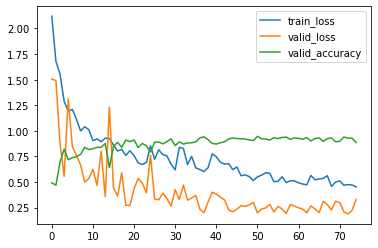

In [38]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### LoudnessControl

In [39]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'LoudnessControl', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.6863745289845176
TEST
loss: 2.457658019629858
accuracy: 0.24086021505376345
******************
epoch: 1
Train
0.8358410680942402
TEST
loss: 3.0399127652568203
accuracy: 0.33763440860215055
******************
epoch: 2
Train
0.5844713566954186
TEST
loss: 1.0232233262831165
accuracy: 0.6494623655913978
******************
epoch: 3
Train
0.4563254471677699
TEST
loss: 3.6747678572131743
accuracy: 0.24731182795698925
******************
epoch: 4
Train
0.4165905730083673
TEST
loss: 2.055481130333357
accuracy: 0.4881720430107527
******************
epoch: 5
Train
0.4940069210933753
TEST
loss: 1.1823757243412798
accuracy: 0.6
******************
epoch: 6
Train
0.45209982411862704
TEST
loss: 1.3023147226661764
accuracy: 0.6172043010752688
******************
epoch: 7
Train
0.31254309078795844
TEST
loss: 1.313305482556743
accuracy: 0.6494623655913978
******************
epoch: 8
Train
0.3306440358272341
TEST
loss: 0.8063614012092672
accuracy: 0.75268817204

In [40]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9070567986230637


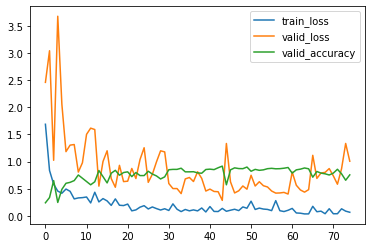

In [41]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeNoising

In [42]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.1295017877700961
TEST
loss: 0.9210959901091873
accuracy: 0.7698924731182796
******************
epoch: 1
Train
0.4827891681293165
TEST
loss: 1.3154855623040147
accuracy: 0.7053763440860215
******************
epoch: 2
Train
0.389962873474269
TEST
loss: 0.679875551244264
accuracy: 0.8301075268817204
******************
epoch: 3
Train
0.3496433025287182
TEST
loss: 0.27493309359396656
accuracy: 0.9139784946236559
******************
epoch: 4
Train
0.23494395807858878
TEST
loss: 0.3677154120578561
accuracy: 0.886021505376344
******************
epoch: 5
Train
0.2283991615362686
TEST
loss: 0.5252261784768874
accuracy: 0.8838709677419355
******************
epoch: 6
Train
0.27080994016728094
TEST
loss: 0.7872193821014897
accuracy: 0.7913978494623656
******************
epoch: 7
Train
0.3042467456385212
TEST
loss: 0.8169145704597556
accuracy: 0.7935483870967742
******************
epoch: 8
Train
0.2058539729511218
TEST
loss: 0.4490808767016216
accuracy: 

In [43]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9518072289156626


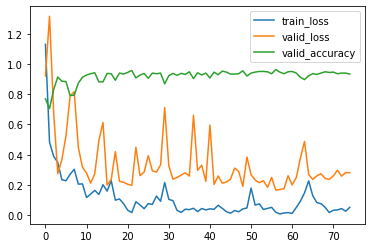

In [44]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqNoising

In [45]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.184595586281665
TEST
loss: 1.385475948292722
accuracy: 0.6795698924731183
******************
epoch: 1
Train
0.47783130423382014
TEST
loss: 0.43988210385845555
accuracy: 0.8580645161290322
******************
epoch: 2
Train
0.4092330036461193
TEST
loss: 0.49782992819304106
accuracy: 0.8666666666666667
******************
epoch: 3
Train
0.25894755202079245
TEST
loss: 0.4501463556802401
accuracy: 0.8817204301075269
******************
epoch: 4
Train
0.29403615726471977
TEST
loss: 0.2682335513894276
accuracy: 0.9096774193548387
******************
epoch: 5
Train
0.2407311051201294
TEST
loss: 0.6912554481978057
accuracy: 0.832258064516129
******************
epoch: 6
Train
0.2826515795982969
TEST
loss: 0.38914359051694153
accuracy: 0.8795698924731182
******************
epoch: 7
Train
0.3517764668729142
TEST
loss: 0.8700996775780955
accuracy: 0.7849462365591398
******************
epoch: 8
Train
0.2433190076147027
TEST
loss: 0.29053062239000876
accura

In [46]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9569707401032702


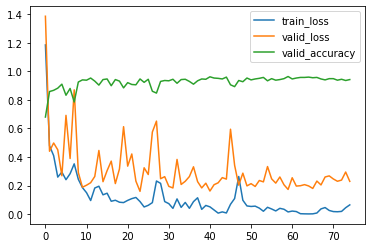

In [47]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeCycleShift

In [48]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.1613846607084999
TEST
loss: 1.0081065306099513
accuracy: 0.7354838709677419
******************
epoch: 1
Train
0.5218844445854602
TEST
loss: 0.5358850725235478
accuracy: 0.8279569892473119
******************
epoch: 2
Train
0.4961504878443162
TEST
loss: 0.45489942002040085
accuracy: 0.8559139784946237
******************
epoch: 3
Train
0.40897478785127095
TEST
loss: 0.3555868496177017
accuracy: 0.8817204301075269
******************
epoch: 4
Train
0.29981270642709396
TEST
loss: 0.6242131815161757
accuracy: 0.8473118279569892
******************
epoch: 5
Train
0.3612404174232072
TEST
loss: 0.6433132046012469
accuracy: 0.8344086021505376
******************
epoch: 6
Train
0.29615494032732953
TEST
loss: 0.36663954770693213
accuracy: 0.9010752688172043
******************
epoch: 7
Train
0.3089192051623031
TEST
loss: 0.3056029052503647
accuracy: 0.9053763440860215
******************
epoch: 8
Train
0.27844761585637196
TEST
loss: 0.4146410628352114
accu

In [49]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


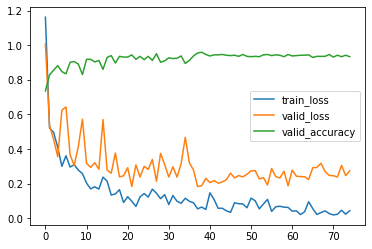

In [50]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqCycleShift

In [51]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
2.0545957349100354
TEST
loss: 3.1186092253654234
accuracy: 0.43655913978494626
******************
epoch: 1
Train
1.6054909772364503
TEST
loss: 1.3412182707940379
accuracy: 0.5978494623655914
******************
epoch: 2
Train
1.3353708848301031
TEST
loss: 0.6362383893741075
accuracy: 0.8043010752688172
******************
epoch: 3
Train
1.19176521118957
TEST
loss: 0.8167816778664948
accuracy: 0.7225806451612903
******************
epoch: 4
Train
1.1416101585361478
TEST
loss: 0.8861363962132444
accuracy: 0.7182795698924731
******************
epoch: 5
Train
1.105008429844147
TEST
loss: 0.9404416820054413
accuracy: 0.7397849462365591
******************
epoch: 6
Train
1.1426905367922642
TEST
loss: 0.9926559543096891
accuracy: 0.7397849462365591
******************
epoch: 7
Train
0.9998233166829706
TEST
loss: 0.45154556253904937
accuracy: 0.8473118279569892
******************
epoch: 8
Train
0.9875272376985401
TEST
loss: 0.43268891438361134
accuracy: 

In [52]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9311531841652324


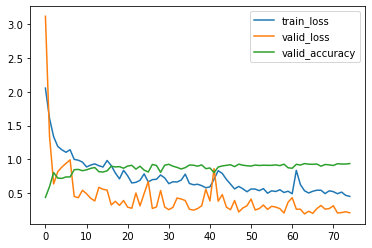

In [53]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSpecialShift

In [54]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.279480718706138
TEST
loss: 0.5964061403787264
accuracy: 0.8172043010752689
******************
epoch: 1
Train
0.49396935058782737
TEST
loss: 0.6180031407263971
accuracy: 0.8258064516129032
******************
epoch: 2
Train
0.4415245162715306
TEST
loss: 0.5728151936684885
accuracy: 0.8150537634408602
******************
epoch: 3
Train
0.4474600801945503
TEST
loss: 1.1604688264990366
accuracy: 0.7182795698924731
******************
epoch: 4
Train
0.33595736705942314
TEST
loss: 0.3850266466858566
accuracy: 0.9053763440860215
******************
epoch: 5
Train
0.32588269675875714
TEST
loss: 1.0743972716792938
accuracy: 0.7655913978494624
******************
epoch: 6
Train
0.37328743215652327
TEST
loss: 0.460248020643829
accuracy: 0.8602150537634409
******************
epoch: 7
Train
0.23333568727385953
TEST
loss: 0.2752941566128885
accuracy: 0.9161290322580645
******************
epoch: 8
Train
0.24892088831851222
TEST
loss: 0.22141687088115242
accur

In [55]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9432013769363167


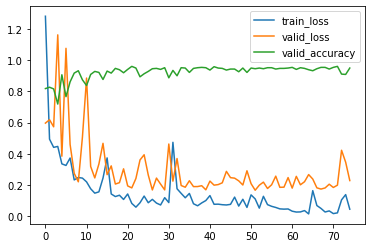

In [56]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSpecialShift

In [57]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
2.1022953654593786
TEST
loss: 2.010783378539547
accuracy: 0.3870967741935484
******************
epoch: 1
Train
1.5324247762857743
TEST
loss: 0.7290221624476936
accuracy: 0.7569892473118279
******************
epoch: 2
Train
1.4056736782281452
TEST
loss: 3.2882371394864975
accuracy: 0.4043010752688172
******************
epoch: 3
Train
1.1938060966947737
TEST
loss: 0.6117242877201368
accuracy: 0.8150537634408602
******************
epoch: 4
Train
1.1531727464210622
TEST
loss: 1.1927447129321356
accuracy: 0.7204301075268817
******************
epoch: 5
Train
1.1833106779448757
TEST
loss: 0.8493173754343423
accuracy: 0.7591397849462366
******************
epoch: 6
Train
1.0972879809850509
TEST
loss: 0.4884673495446482
accuracy: 0.853763440860215
******************
epoch: 7
Train
0.9423860150379845
TEST
loss: 0.43882624782541746
accuracy: 0.8473118279569892
******************
epoch: 8
Train
1.0544987305172298
TEST
loss: 0.46843682540360315
accuracy: 

In [58]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9414802065404475


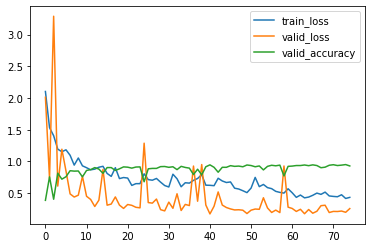

In [59]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSwapAugmentation

In [60]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.0659067880484643
TEST
loss: 1.1696101973133703
accuracy: 0.7204301075268817
******************
epoch: 1
Train
0.5053169295938027
TEST
loss: 0.6296662833101005
accuracy: 0.8064516129032258
******************
epoch: 2
Train
0.38183334763485316
TEST
loss: 0.3923782507578532
accuracy: 0.8838709677419355
******************
epoch: 3
Train
0.36713814388762
TEST
loss: 0.8988286146553613
accuracy: 0.7612903225806451
******************
epoch: 4
Train
0.337034895590832
TEST
loss: 0.45634831638746365
accuracy: 0.875268817204301
******************
epoch: 5
Train
0.2972842950813219
TEST
loss: 0.42262959928922755
accuracy: 0.8688172043010752
******************
epoch: 6
Train
0.31432135161624264
TEST
loss: 0.31502845325777606
accuracy: 0.9118279569892473
******************
epoch: 7
Train
0.24919189117130697
TEST
loss: 0.32020931807897424
accuracy: 0.9010752688172043
******************
epoch: 8
Train
0.215832480433556
TEST
loss: 0.4984313253433474
accuracy

In [61]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9432013769363167


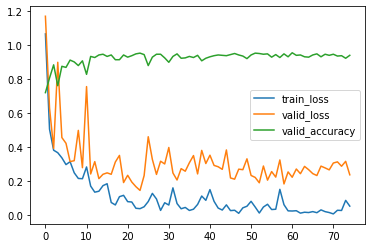

In [62]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSwapAugmentation

In [63]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.2753140981568403
TEST
loss: 0.7491909201427173
accuracy: 0.7548387096774194
******************
epoch: 1
Train
0.5786228943846851
TEST
loss: 0.4425640066464742
accuracy: 0.8666666666666667
******************
epoch: 2
Train
0.5838775338186779
TEST
loss: 0.4832544877964963
accuracy: 0.8580645161290322
******************
epoch: 3
Train
0.3334818692636156
TEST
loss: 0.24977673202432613
accuracy: 0.9053763440860215
******************
epoch: 4
Train
0.3135771436850487
TEST
loss: 0.44068406884388256
accuracy: 0.8559139784946237
******************
epoch: 5
Train
0.34839916768482315
TEST
loss: 0.5494441224682716
accuracy: 0.8365591397849462
******************
epoch: 6
Train
0.36466861990875754
TEST
loss: 0.4494296896842218
accuracy: 0.8709677419354839
******************
epoch: 7
Train
0.2713493559716142
TEST
loss: 0.36367648891223375
accuracy: 0.8838709677419355
******************
epoch: 8
Train
0.28115095922750494
TEST
loss: 0.3871415475363372
accu

In [64]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9483648881239243


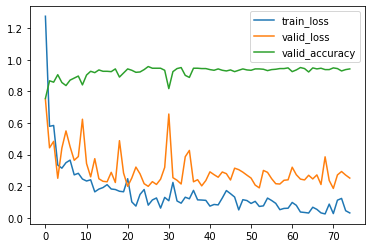

In [65]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeReplyMasking

In [66]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.0756828049273022
TEST
loss: 0.8729348969715898
accuracy: 0.7720430107526882
******************
epoch: 1
Train
0.48824890018087214
TEST
loss: 0.8235564981737444
accuracy: 0.7806451612903226
******************
epoch: 2
Train
0.4388398116932932
TEST
loss: 0.3565399524986103
accuracy: 0.9010752688172043
******************
epoch: 3
Train
0.2675608216785396
TEST
loss: 0.43733634769275626
accuracy: 0.8881720430107527
******************
epoch: 4
Train
0.3343925197469848
TEST
loss: 0.23796010530123146
accuracy: 0.9182795698924732
******************
epoch: 5
Train
0.29283436030293897
TEST
loss: 0.530023830680437
accuracy: 0.8344086021505376
******************
epoch: 6
Train
0.27199662052692747
TEST
loss: 0.5578876044160577
accuracy: 0.8623655913978494
******************
epoch: 7
Train
0.28615987024836215
TEST
loss: 0.24430390904026647
accuracy: 0.9290322580645162
******************
epoch: 8
Train
0.1761318036767829
TEST
loss: 0.30202723215985045
acc

In [67]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9500860585197934


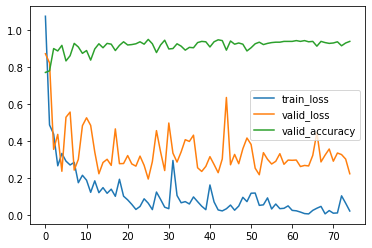

In [68]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqReplyMasking

In [69]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.155591716545528
TEST
loss: 0.9877005120759369
accuracy: 0.7784946236559139
******************
epoch: 1
Train
0.5190479433144942
TEST
loss: 0.568080844161331
accuracy: 0.8279569892473119
******************
epoch: 2
Train
0.45151423586268674
TEST
loss: 0.4024342945826951
accuracy: 0.8688172043010752
******************
epoch: 3
Train
0.3570083614055611
TEST
loss: 0.8642134174223869
accuracy: 0.8064516129032258
******************
epoch: 4
Train
0.3345821558562542
TEST
loss: 0.4466474889427103
accuracy: 0.8795698924731182
******************
epoch: 5
Train
0.2759356166190464
TEST
loss: 0.42937952600499635
accuracy: 0.886021505376344
******************
epoch: 6
Train
0.28890156755539825
TEST
loss: 0.9909296138312227
accuracy: 0.8064516129032258
******************
epoch: 7
Train
0.33762377996437
TEST
loss: 0.5928967105445041
accuracy: 0.8301075268817204
******************
epoch: 8
Train
0.23110037031004232
TEST
loss: 0.3487924293805194
accuracy: 0

In [70]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9466437177280551


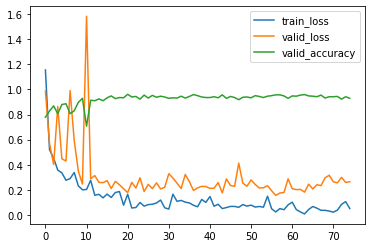

In [71]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeRandomSwap

In [72]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.1809424644654067
TEST
loss: 1.1112281994153095
accuracy: 0.7311827956989247
******************
epoch: 1
Train
0.5304026041354425
TEST
loss: 0.43839306933905486
accuracy: 0.8516129032258064
******************
epoch: 2
Train
0.41804389280854337
TEST
loss: 0.4047223328262247
accuracy: 0.8602150537634409
******************
epoch: 3
Train
0.3384209969830757
TEST
loss: 0.7072153445213072
accuracy: 0.832258064516129
******************
epoch: 4
Train
0.2923249313763283
TEST
loss: 0.39981750121680637
accuracy: 0.8774193548387097
******************
epoch: 5
Train
0.35222269805708945
TEST
loss: 0.5302208239032377
accuracy: 0.8580645161290322
******************
epoch: 6
Train
0.2775555515745088
TEST
loss: 0.42716140849615936
accuracy: 0.8989247311827957
******************
epoch: 7
Train
0.2806620963427349
TEST
loss: 0.30421213642243417
accuracy: 0.896774193548387
******************
epoch: 8
Train
0.20281510530907298
TEST
loss: 0.3353367931099348
accur

In [73]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


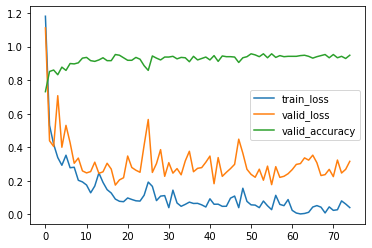

In [74]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqRandomSwap

In [75]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.4231726896011772
TEST
loss: 0.9325943582801408
accuracy: 0.7763440860215054
******************
epoch: 1
Train
0.6729270008602769
TEST
loss: 0.4894236708200106
accuracy: 0.8666666666666667
******************
epoch: 2
Train
0.5653753863526212
TEST
loss: 0.4790731281362554
accuracy: 0.8344086021505376
******************
epoch: 3
Train
0.4390629913194499
TEST
loss: 0.4513923005391193
accuracy: 0.8903225806451613
******************
epoch: 4
Train
0.4597802077433597
TEST
loss: 0.4046813575170373
accuracy: 0.8817204301075269
******************
epoch: 5
Train
0.3978051904330153
TEST
loss: 0.5366501364656674
accuracy: 0.8494623655913979
******************
epoch: 6
Train
0.44398194407030145
TEST
loss: 0.32142835586301743
accuracy: 0.9053763440860215
******************
epoch: 7
Train
0.3444036647845932
TEST
loss: 0.283398865115258
accuracy: 0.9118279569892473
******************
epoch: 8
Train
0.2779991828952352
TEST
loss: 0.28560128237611504
accuracy

In [76]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9397590361445783


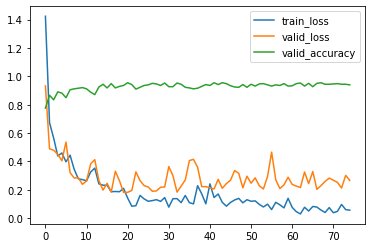

In [77]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()